In [71]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import torch
import torch.optim as optim
# from tensorboardX import SummaryWriter
import numpy as np
import os
import argparse
import time
import matplotlib

# Helper Functions for the basis changing while projecting points to the plane

In [72]:
def SingleChangeBasisMatrix(single_plane_parameter):
    a, b, c, _ = single_plane_parameter
    a, b, c = float(a), float(b), float(c)

    normal = np.array([a, b, c])
    normal = normal / np.sqrt(np.sum(normal ** 2))

    if sum(normal == np.array([0, 0, 1])) != 3:
        basis_x = np.array([1, 0, 0])
        basis_y = np.array([0, 1, 0])
        basis_z = np.array([0, 0, 1])

        # Construct rotation matrix to align z-axis basis to plane normal
        # Need to add exception, if normal = [0, 0, 1]. don't do basis rotation
        v = np.cross(basis_z, normal)
        ssc = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
        R = np.identity(3) + ssc + np.matmul(ssc, ssc) * \
            (1 - np.dot(normal, basis_z)) / (np.linalg.norm(v) ** 2)

        # Change basis to plane normal basis
        # plane equation in new basis: z = 0
        # plane normal basis in standard coordinate
        new_basis_x = np.array([np.matmul(R, basis_x)])
        new_basis_y = np.array([np.matmul(R, basis_y)])
        new_basis_z = np.array([np.matmul(R, basis_z)])
        new_basis_matrix = np.concatenate(
            (new_basis_x.T, new_basis_y.T, new_basis_z.T), axis=1)

        C_inv = np.linalg.inv(new_basis_matrix)

    else:
        C_inv = np.identity(3)

    return C_inv, new_basis_matrix



def ChangeBasisMatrix(plane_parameters):
    # Input: Plane parameters (Lx4)
    # Output: Change of basis matrices (L x 3 x 3)
    L = len(plane_parameters)
    mat = SingleChangeBasisMatrix(plane_parameters[0])

    for i in range(1, L):
        mat = np.vstack((mat, SingleChangeBasisMatrix(plane_parameters[i])))

    mat = mat.reshape((L, 3, 3)).T
    mat = torch.tensor(mat, device='cuda')
    return mat

# Visualisation for one plane

tensor([[0.5000, 0.5000, 0.5000, 0.2000],
        [1.0000, 0.0000, 0.0000, 2.0000],
        [1.0000, 4.0000, 2.0000, 5.0000]], dtype=torch.float64)


<IPython.core.display.Javascript object>


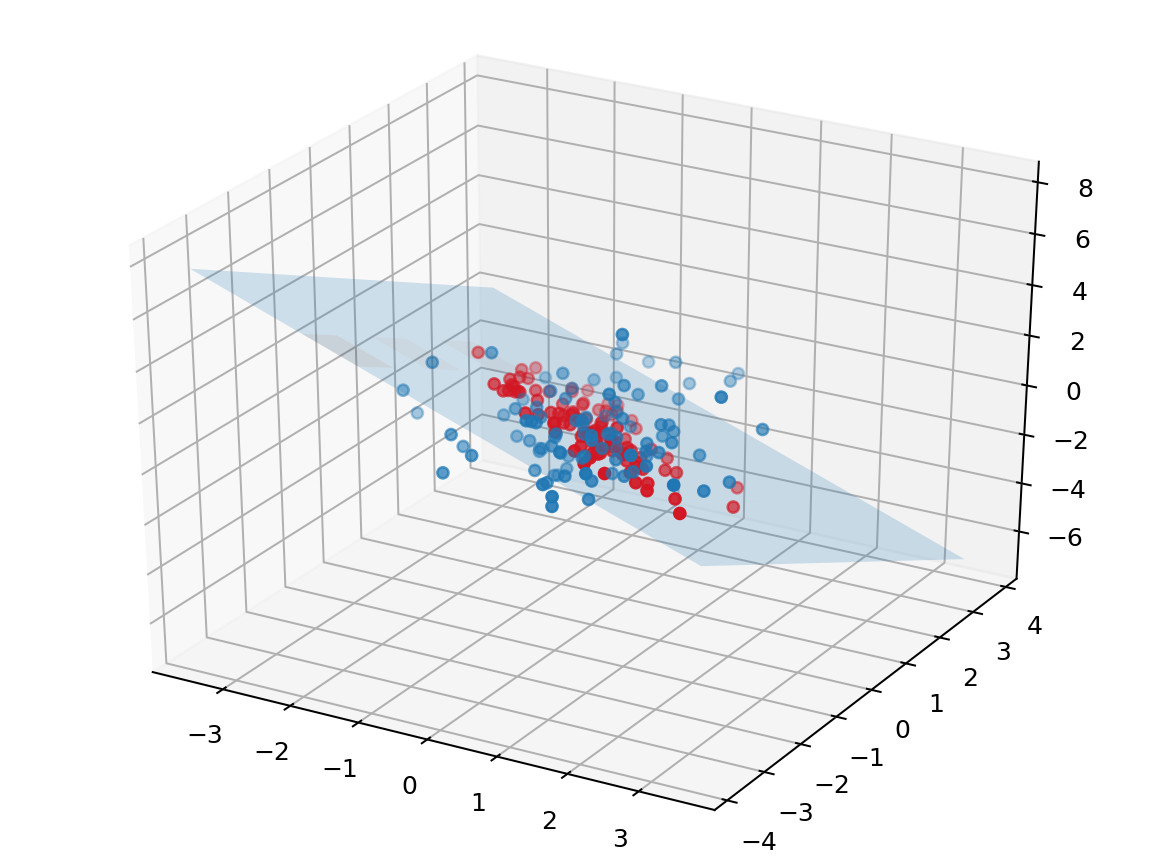

In [73]:

# Points in original coordinates

plane_param_np = np.array([[0.5, 0.5, 0.5, 0.2], [1, 0, 0, 2], [1, 4, 2, 5]])
plane_parameters = torch.tensor(plane_param_np)
print(plane_parameters)
p = torch.randn([3, 100, 3])
p = p[:, 0:100, :]  # Take 100 points
p = p.to('cpu')
p = p.numpy()
p = p[0]  # 100 points in first batch

# Change of basis matrix
C_inv, C = SingleChangeBasisMatrix(plane_parameters[0])

# p_project is in plane basis
p_project = np.matmul(p, C_inv)  # First plane
p_project[:, 2] = 0  # Project z coordinates to "ground"

# Convert back to earth basis
p_project_earthbasis = np.matmul(C, p_project.T).T

# Visualize

fig = plt.figure()
ax = Axes3D(fig)
# ax = plt.axes(projection='3d')
# ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
ax.scatter3D(p[:, 0], p[:, 1], p[:, 2], cmap='Greens')
ax.scatter3D(p_project_earthbasis[:, 0], p_project_earthbasis[:,
                                                              1], p_project_earthbasis[:, 2], color='red')

a, b, c, d = plane_parameters[0].numpy()


#define the square in xy which contains all points of reconstructed object for the plane drawing in this range

#if p is a torch tensor this will work
#define the square in xy which contains all points of reconstructed object for the plane drawing in this range
# min_val, _ = torch.min(p, dim=0, keepdim=True)
# max_val, _ = torch.max(p, dim=0, keepdim=True)
# max_abs_width = max(abs(min_val[0][0].item()), max_val[0][0].item()) + 1
# max_abs_height = max(abs(min_val[0][1].item()), max_val[0][1].item()) + 1

min_val = np.amin(p, axis = 0)
max_val = np.amax(p, axis =0)
max_abs_width = max(abs(min_val[0]), max_val[0]) + 1
max_abs_height = max(abs(min_val[1]), max_val[1]) + 1


x = np.linspace(-max_abs_width, max_abs_width, 10)
y = np.linspace(-max_abs_height, max_abs_height, 10)

X, Y = np.meshgrid(x, y)
Z = (d - a*X - b*Y) / c


# fig = plt.figure()
# ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, alpha=0.2)


plt.show()
plt.savefig('illust1.jpg')


# Visualisation for two planes

tensor([[0.5000, 0.5000, 0.5000, 0.2000],
        [1.0000, 0.0000, 5.0000, 2.0000],
        [1.0000, 4.0000, 2.0000, 5.0000]], dtype=torch.float64)


<IPython.core.display.Javascript object>


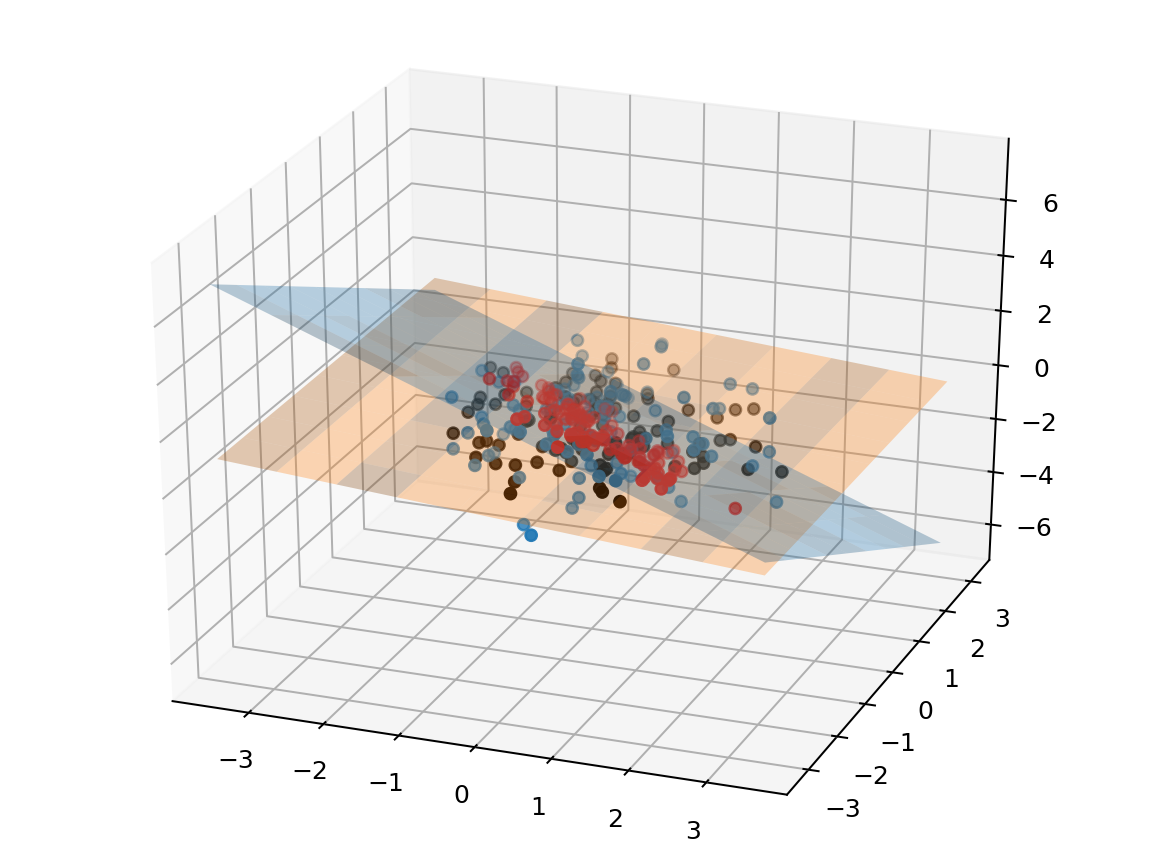

0.5 0.5 0.5 0.2
1.0 0.0 5.0 2.0


In [74]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import torch
import torch.optim as optim
# from tensorboardX import SummaryWriter
import numpy as np
import os
import argparse
import time
import matplotlib



# Points in original coordinates

plane_param_np = np.array([[0.5, 0.5, 0.5, 0.2], [1, 0, 5, 2], [1, 4, 2, 5]])
plane_parameters = torch.tensor(plane_param_np)
print(plane_parameters)
#just for a toy example we initialise 3d points p as a random tensor
p = torch.randn([3, 100, 3])
p = p[:, 0:100, :]  # Take 100 points
p = p.to('cpu')
p = p.numpy()
p = p[0]  # 100 points in first batch

# Change of basis matrix
C_inv, C = SingleChangeBasisMatrix(plane_parameters[0])

C_inv1, C1 = SingleChangeBasisMatrix(plane_parameters[1])

# p_project is in plane basis
p_project = np.matmul(p, C_inv)  # First plane
p_project1 = np.matmul(p, C_inv1)  # Second plane

p_project[:, 2] = 0  # Project z coordinates to "ground"
p_project1[:, 2] = 0
# Convert back to earth basis
p_project_earthbasis = np.matmul(C, p_project.T).T

p_project_earthbasis1 = np.matmul(C1, p_project1.T).T
# Visualize

%matplotlib notebook
fig = plt.figure()
ax = Axes3D(fig)
# ax = plt.axes(projection='3d')
# ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
ax.scatter3D(p[:, 0], p[:, 1], p[:, 2], cmap='Greens')
ax.scatter3D(p_project_earthbasis[:, 0], p_project_earthbasis[:,
                                                              1], p_project_earthbasis[:, 2], color='red')

ax.scatter3D(p_project_earthbasis1[:, 0], p_project_earthbasis1[:,
                                                              1], p_project_earthbasis1[:, 2], color='black')

a, b, c, d = plane_parameters[0].numpy()
print(a, b, c, d)
a1, b1, c1, d1 = plane_parameters[1].numpy()
print(a1, b1, c1, d1)
#define the square in xy which contains all points of reconstructed object for the plane drawing in this range
# min_val, _ = torch.min(p, dim=0, keepdim=True)
# max_val, _ = torch.max(p, dim=0, keepdim=True)
# max_abs_width = max(abs(min_val[0][0].item()), max_val[0][0].item()) + 1
# max_abs_height = max(abs(min_val[0][1].item()), max_val[0][1].item()) + 1

min_val = np.amin(p, axis = 0)
max_val = np.amax(p, axis =0)
max_abs_width = max(abs(min_val[0]), max_val[0]) + 1
max_abs_height = max(abs(min_val[1]), max_val[1]) + 1


x = np.linspace(-max_abs_width, max_abs_width, 10)
y = np.linspace(-max_abs_height, max_abs_height, 10)

X, Y = np.meshgrid(x, y)
X1, Y1 = np.meshgrid(x, y)
Z = (d - a*X - b*Y) / c
Z1 = (d1 - a1*X - b1*Y) / c1

# fig = plt.figure()
# ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, alpha=0.3)

surf1 = ax.plot_surface(X1, Y1, Z1, alpha=0.3)

plt.show()
plt.savefig('illust2.jpg')


# Code which will upload points from our real datasets (instead of random tensor p)

In [ ]:
from tensorboardX import SummaryWriter
import numpy as np
import os
import argparse
import time
import matplotlib;

matplotlib.use('Agg')
from im2mesh import config, data
from im2mesh.checkpoints import CheckpointIO

'''
 Set cuda = True. If False, change:
 mat = torch.tensor(mat, device='cuda')
 grid_feature = torch.zeros([net.size()[0], C_mat.size()[0], W, H, net.size()[2]], device='cuda')
 counter = torch.zeros([net.size()[0], C_mat.size()[0], W, H, net.size()[2]], device='cuda')

 to:
 mat = torch.tensor(mat)
 grid_feature = torch.zeros([net.size()[0], C_mat.size()[0], W, H, net.size()[2]])
 counter = torch.zeros([net.size()[0], C_mat.size()[0], W, H, net.size()[2]])

 and delete:
 net = net.to(device)
 p_project = p_project.to(device)
'''
is_cuda = True

cfg = config.load_config('configs/pointcloud/onet.yaml', 'configs/default.yaml')
device = torch.device("cuda" if is_cuda else "cpu")

# Set t0
t0 = time.time()

# Shorthands
out_dir = cfg['training']['out_dir']
batch_size = cfg['training']['batch_size']
backup_every = cfg['training']['backup_every']
# exit_after = args.exit_after

model_selection_metric = cfg['training']['model_selection_metric']
if cfg['training']['model_selection_mode'] == 'maximize':
    model_selection_sign = 1
elif cfg['training']['model_selection_mode'] == 'minimize':
    model_selection_sign = -1
else:
    raise ValueError('model_selection_mode must be '
                     'either maximize or minimize.')

# Output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Dataset
train_dataset = config.get_dataset('train', cfg)
val_dataset = config.get_dataset('val', cfg)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=4, shuffle=True,
    collate_fn=data.collate_remove_none,
    worker_init_fn=data.worker_init_fn)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=10, num_workers=4, shuffle=False,
    collate_fn=data.collate_remove_none,
    worker_init_fn=data.worker_init_fn)

# For visualizations
vis_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=12, shuffle=True,
    collate_fn=data.collate_remove_none,
    worker_init_fn=data.worker_init_fn)
data_vis = next(iter(vis_loader))

# Model
model = config.get_model(cfg, device=device, dataset=train_dataset)

# Intialize training
npoints = 1000
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
trainer = config.get_trainer(model, optimizer, cfg, device=device)

checkpoint_io = CheckpointIO(out_dir, model=model, optimizer=optimizer)
try:
    load_dict = checkpoint_io.load('model.pt')
except FileExistsError:
    load_dict = dict()
epoch_it = load_dict.get('epoch_it', -1)
it = load_dict.get('it', -1)
metric_val_best = load_dict.get(
    'loss_val_best', -model_selection_sign * np.inf)

# Hack because of previous bug in code
# TODO: remove, because shouldn't be necessary
if metric_val_best == np.inf or metric_val_best == -np.inf:
    metric_val_best = -model_selection_sign * np.inf

# TODO: remove this switch
# metric_val_best = -model_selection_sign * np.inf

print('Current best validation metric (%s): %.8f'
      % (model_selection_metric, metric_val_best))

# TODO: reintroduce or remove scheduler?
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4000,
#                                       gamma=0.1, last_epoch=epoch_it)
logger = SummaryWriter(os.path.join(out_dir, 'logs'))

# Shorthands
print_every = cfg['training']['print_every']
checkpoint_every = cfg['training']['checkpoint_every']
validate_every = cfg['training']['validate_every']
visualize_every = cfg['training']['visualize_every']

# Print model
nparameters = sum(p.numel() for p in model.parameters())
print(model)
print('Total number of parameters: %d' % nparameters)

# Get sample points
for batch in train_loader:
    a = batch
p = a['points']